In [1]:
import numpy as np
from typing import Union, Iterable, Sized, Tuple
import torch
import torch.nn.functional as F
from torch.distributions.uniform import Uniform
import matplotlib.pyplot as plt
import math
import os
import random
import logging
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torchinfo import summary

from data_processing.data_loader import *
from model.activation_layers import ExULayer, ReLULayer, LipschitzMonotonicLayer
from model.model_network import HierarchNeuralAdditiveModel
from utils.model_architecture_type import get_defult_architecture_phase1, get_defult_architecture_phase2
from training.trainer import Trainer
from utils.utils import define_device, seed_everything
from utils.model_parser import parse_args


In [2]:
# import wandb
# wandb.login()

# run = wandb.init(
#     project="nam-original",
#     notes="My first experiment",
#     tags=["baseline"],
# )

In [3]:
# Parsing arguments
args = parse_args()

# Set device and seed
device = define_device("auto")
print(device)

seed_everything(args.seed)

cuda


In [4]:
args.featureNN_arch_phase1='multi_output'#'single_to_multi_output'
args.featureNN_arch_phase2='multi_output'#'parallel_single_output'


DATA PROCESSING

In [5]:
# Generate synthetic data for Phase 1 and Phase 2
X, y_phase1 = SyntheticDatasetGenerator.get_synthetic_data_phase1(args.num_exp, args.in_features)
y_phase2 = SyntheticDatasetGenerator.get_synthetic_data_phase2(y_phase1)

SyntheticDataset= True
if SyntheticDataset:
    # Generate synthetic data for validation set
    X_val, y_phase1_val = SyntheticDatasetGenerator.get_synthetic_data_phase1(5000, args.in_features)
    y_phase2_val = SyntheticDatasetGenerator.get_synthetic_data_phase2(y_phase1_val)

    train_loader = SyntheticDatasetGenerator.make_loader(X, y_phase2, batch_size=args.batch_size)
    val_loader = SyntheticDatasetGenerator.make_loader(X_val, y_phase2_val, batch_size=args.batch_size)
else:
    # Initialize DataLoaderWrapper with validation split
    dataloader_wrapper = DataLoaderWrapper(X, y_phase2, val_split=args.val_split)
    # Create DataLoaders
    train_loader, val_loader = dataloader_wrapper.create_dataloaders()

# Print the size of training and validation datasets
print("Train size:", len(train_loader.dataset), "Val size:", len(val_loader.dataset))

torch.Size([50000, 10])
torch.Size([50000, 4])
torch.Size([50000, 2])
torch.Size([5000, 10])
torch.Size([5000, 4])
torch.Size([5000, 2])
Train size: 50000 Val size: 5000


Initialaize Model 

In [6]:
# Model definition: HierarchNeuralAdditiveModel
model = HierarchNeuralAdditiveModel(num_inputs=args.in_features,
                                    task_type= args.task_type,
                                    hierarch_net= args.hierarch_net,
                                    #phase1 - latent_features:
                                    num_units_phase1= args.first_hidden_dim_phase1,
                                    hidden_units_phase1 = args.hidden_dim_phase1,
                                    hidden_dropout_phase1 =args.hidden_dropout_phase1,
                                    feature_dropout_phase1 = args.feature_dropout_phase1,
                                    shallow_phase1 = args.shallow_phase1,
                                    first_layer_phase1 = args.first_activate_layer_phase1,
                                    hidden_layer_phase1= args.hidden_activate_layer_phase1,         
                                    latent_var_dim= args.latent_dim,
                                    featureNN_architecture_phase1= args.featureNN_arch_phase1,
                                    weight_norms_kind_phase1= args.weight_norms_kind_phase1, 
                                    group_size_phase1= args.group_size_phase1, 
                                    monotonic_constraint_phase1= args.monotonic_constraint_phase1,
                                    #phase2 - final outputs:
                                    num_units_phase2= args.first_hidden_dim_phase2,
                                    hidden_units_phase2 = args.hidden_dim_phase2,
                                    hidden_dropout_phase2 = args.hidden_dropout_phase2,
                                    feature_dropout_phase2 = args.feature_dropout_phase1,
                                    shallow_phase2 = args.shallow_phase2,
                                    first_layer_phase2 = args.first_activate_layer_phase2,
                                    hidden_layer_phase2 = args.hidden_activate_layer_phase2,          
                                    output_dim = args.output_dim,
                                    featureNN_architecture_phase2 = args.featureNN_arch_phase2,
                                    weight_norms_kind_phase2 = args.weight_norms_kind_phase2, 
                                    group_size_phase2 = args.group_size_phase2, 
                                    monotonic_constraint_phase2 = args.monotonic_constraint_phase2
                                    ).to(device)

# model = HierarchNeuralAdditiveModel(num_inputs=10, 
#                                     output_dim = 2, 
#                                     latent_var_dim = 4, 
#                                     task_type = 'regression', 
#                                     hierarch_net = True,
#                                     first_layer_phase1 = 'ReLU',
#                                     hidden_layer_phase1 = 'ReLU',
#                                     first_layer_phase2 = 'LipschitzMonotonic',
#                                     hidden_layer_phase2 = 'LipschitzMonotonic',
#                                     shallow_phase1 = False,
#                                     shallow_phase2 = False
#                                     ).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

if 0:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f'{name}: {param.numel()} parameters')
if 0:
    print(summary(model,input_size=(1, 10)))

Number of parameters: 199324


Train the model

In [7]:

# Initialize the Trainer class
trainer = Trainer(
        model=model,
        optimizer=args.optimizer,
        loss_function=None,
        lr_scheduler=args.lr_scheduler, 
        scheduler_params=None,
        eval_metric=None, 
        epochs=args.epochs, 
        batch_size=args.batch_size, 
        learning_rate=args.learning_rate, 
        weight_decay=args.weight_decay, 
        l1_lambda_phase1=args.l1_lambda_phase1,
        l1_lambda_phase2=args.l1_lambda_phase2,
        l2_lambda_phase1=args.l2_lambda_phase1,
        l2_lambda_phase2=args.l2_lambda_phase2,
        eval_every=args.eval_every,
        early_stop_delta=args.early_stop_delta,
        early_stop_patience=args.early_stop_patience,
        clip_value=args.clip_value,
        device_name="auto"
)

# Run the training phase
train_loss_history, val_loss_history = trainer.train(train_loader)

  0%|          | 1/2000 [00:15<8:45:45, 15.78s/it]

Epoch 0 | Total Loss: 628.53298


  0%|          | 2/2000 [00:38<11:05:05, 19.97s/it]

Epoch 1 | Total Loss: 273.42626


  0%|          | 3/2000 [00:55<10:12:05, 18.39s/it]

Epoch 2 | Total Loss: 251.43533


  0%|          | 4/2000 [01:10<9:31:28, 17.18s/it] 

Epoch 3 | Total Loss: 239.04504


  0%|          | 5/2000 [01:27<9:26:51, 17.05s/it]

Epoch 4 | Total Loss: 233.73788


  0%|          | 6/2000 [01:42<9:08:02, 16.49s/it]

Epoch 5 | Total Loss: 231.31125


  0%|          | 7/2000 [01:58<8:57:47, 16.19s/it]

Epoch 6 | Total Loss: 224.16318


  0%|          | 8/2000 [02:14<8:52:56, 16.05s/it]

Epoch 7 | Total Loss: 222.18829


  0%|          | 9/2000 [02:29<8:50:53, 16.00s/it]

Epoch 8 | Total Loss: 219.24579


  0%|          | 10/2000 [02:46<8:56:26, 16.17s/it]

Epoch 9 | Total Loss: 216.98772


  1%|          | 11/2000 [03:04<9:16:42, 16.79s/it]

Epoch 10 | Total Loss: 213.20250


  1%|          | 12/2000 [03:20<9:04:20, 16.43s/it]

Epoch 11 | Total Loss: 212.60625


  1%|          | 13/2000 [03:35<8:54:36, 16.14s/it]

Epoch 12 | Total Loss: 209.74768


  1%|          | 14/2000 [03:56<9:41:03, 17.55s/it]

Epoch 13 | Total Loss: 209.28573


  1%|          | 15/2000 [04:15<9:53:35, 17.94s/it]

Epoch 14 | Total Loss: 204.25249


  1%|          | 16/2000 [04:37<10:30:48, 19.08s/it]

Epoch 15 | Total Loss: 204.08544


  1%|          | 17/2000 [05:01<11:21:07, 20.61s/it]

Epoch 16 | Total Loss: 205.50824


  1%|          | 18/2000 [05:17<10:40:23, 19.39s/it]

Epoch 17 | Total Loss: 202.83426


  1%|          | 19/2000 [05:33<10:03:52, 18.29s/it]

Epoch 18 | Total Loss: 201.93864


  1%|          | 20/2000 [05:51<10:03:59, 18.30s/it]

Epoch 19 | Total Loss: 198.58953


  1%|          | 21/2000 [06:12<10:30:14, 19.11s/it]

Epoch 20 | Total Loss: 198.64255


  1%|          | 22/2000 [06:28<9:55:51, 18.07s/it] 

Epoch 21 | Total Loss: 199.15405


  1%|          | 23/2000 [06:43<9:28:47, 17.26s/it]

Epoch 22 | Total Loss: 197.29695


  1%|          | 24/2000 [06:59<9:10:37, 16.72s/it]

Epoch 23 | Total Loss: 195.62090


  1%|▏         | 25/2000 [07:18<9:29:31, 17.30s/it]

Epoch 24 | Total Loss: 193.21272


  1%|▏         | 26/2000 [07:37<9:50:45, 17.96s/it]

Epoch 25 | Total Loss: 190.84254


  1%|▏         | 27/2000 [07:54<9:43:05, 17.73s/it]

Epoch 26 | Total Loss: 189.75540


  1%|▏         | 28/2000 [08:19<10:49:39, 19.77s/it]

Epoch 27 | Total Loss: 188.39640


  1%|▏         | 29/2000 [08:46<11:58:14, 21.86s/it]

Epoch 28 | Total Loss: 187.64702


  2%|▏         | 30/2000 [09:09<12:10:30, 22.25s/it]

Epoch 29 | Total Loss: 187.84102


  2%|▏         | 31/2000 [09:31<12:09:05, 22.22s/it]

Epoch 30 | Total Loss: 183.91704


  2%|▏         | 31/2000 [09:43<10:17:12, 18.81s/it]


KeyboardInterrupt: 

# Dataset

In [45]:
def get_synthetic_data_phase1(num_exp=10, in_features=10):
    # Simulate independent variables, x0,...,x4 from a Uniform distribution on [−1, 1]
    X_uniform = Uniform(-1, 1).sample((num_exp, in_features-5))
    
    # Simulate features x5 and x6 from a Normal distribution with mean=0 and std=1
    X_normal = torch.normal(0, 1, (num_exp, 5))
    
    # Combine the uniform and normal features
    X = torch.cat([X_uniform, X_normal], dim=1)
    print(X.shape)
    
    # creating y_1
    y_1 = X[:, 0] + 0.5*(3*(X[:, 1]**2)-1) + 0.5*(X[:, 2]**3)
    y_1 = y_1.reshape(-1, 1)
    #print(y_1.shape)
    
    # creating y_2
    y_2 = (1/3) * torch.log(100 * X[:, 5].abs()) + torch.sin(5 * X[:, 6])
    y_2 = y_2.reshape(-1, 1)
    #print(y_2.shape)
    
    # creating y_3
    y_3 = -(3/4) * torch.exp(-4 * X[:, 7].abs()) + torch.cos(5 * X[:, 8])
    y_3 = y_3.reshape(-1, 1)
    
    # creating y_4
    y_4 = torch.sin(5 * X[:, 5]) + 0.5*(3*(X[:, 2]**2)-1)  
    y_4 = y_4.reshape(-1, 1)
    
    # Stack all y_i to form the final target matrix
    y = torch.cat([y_1, y_2, y_3, y_4], dim=1)
    print(y.shape)
    
    return X, y


def get_synthetic_data_phase2(X_input):
    
    # creating y_1
    y_1 = 4*X_input[:, 0] + 0.5*X_input[:, 1]
    y_1 = y_1.reshape(-1, 1)
    #print(y_1.shape)
    
    # creating y_2
    y_2 = (1/3) * X_input[:, 2] + 5 * X_input[:, 3]
    y_2 = y_2.reshape(-1, 1)
    #print(y_2.shape)
    
    # Stack all y_i to form the final target matrix
    y = torch.cat([y_1, y_2], dim=1)
    print(y.shape)
    
    return y


def make_loader(X, y, batch_size):
    dataset = TensorDataset(torch.tensor(X), torch.tensor(y))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

In [46]:
X, y = get_synthetic_data_phase1(num_exp=1, in_features=10)
Y = get_synthetic_data_phase2(y)

torch.Size([1, 10])
torch.Size([1, 4])
torch.Size([1, 2])


# Model architecture

In [47]:
def truncated_normal_(tensor, mean: float = 0., std: float = 1.):
    """
    Initializes a tensor with values from a truncated normal distribution
    """
    size = tensor.shape
    tmp = tensor.new_empty(size + (4,)).normal_()
    valid = (tmp < 2) & (tmp > -2)
    ind = valid.max(-1, keepdim=True)[1]
    tensor.data.copy_(tmp.gather(-1, ind).squeeze(-1))
    tensor.data.mul_(std).add_(mean)

# ActivationLayer Class
class ActivationLayer(torch.nn.Module):
    """
    Abstract base class for layers with weights and biases
    """
    def __init__(self,
                 in_features: int,
                 out_features: int):
        super().__init__()
        
        self.weight = torch.nn.Parameter(torch.empty((in_features, out_features)))
        self.bias = torch.nn.Parameter(torch.empty(in_features))

    def forward(self, x):
        raise NotImplementedError("abstract method called")


class ExULayer(ActivationLayer):
    """
    Custom layer using exponential activation with weight and bias initialization
    """
    def __init__(self,
                 in_features: int,
                 out_features: int):
        super().__init__(in_features, out_features)
        
        truncated_normal_(self.weight, mean=4.0, std=0.5)
        truncated_normal_(self.bias, std=0.5)

    def forward(self, x): 
        exu = (x - self.bias) @ torch.exp(self.weight)
        output = torch.clip(exu, 0, 1)
        
        if 0:
            print('ExULayer_weights:', self.weight.detach().cpu().numpy())
            print('ExULayer Normalization L1\n:', torch.linalg.norm(self.weight.t(), 1, dim=0))
            print('ExULayer Normalization L2\n:',torch.linalg.norm(self.weight.t(), 2, dim=0))
        
        return output


class ReLULayer(ActivationLayer):
    """
    Custom layer using ReLU activation with Xavier weight initialization
    """
    def __init__(self,
                 in_features: int,
                 out_features: int):
        super().__init__(in_features, out_features)
        
        torch.nn.init.xavier_uniform_(self.weight)
        truncated_normal_(self.bias, std=0.5)

    def forward(self, x):
        output = F.relu((x - self.bias) @ self.weight)
        
        if 0:
            print('ReLULayer_weights:', self.weight.detach().cpu().numpy())
            print('ReLULayer Normalization L1:\n', torch.linalg.norm(self.weight.t(), 1, dim=0))
            print('ReLULayer Normalization L2:\n',torch.linalg.norm(self.weight.t(), 2, dim=0))
        
        return output


# FeatureNN Class
class FeatureNN(torch.nn.Module):
    """
    Neural network for individual features
    """
    def __init__(self,
                 shallow_units: int,
                 hidden_units: Tuple = (),
                 shallow_layer: ActivationLayer = ExULayer,
                 hidden_layer: ActivationLayer = ReLULayer,
                 dropout: float = .5,
                 output_dim: int = 1,
                 ):
        super().__init__()
        
        # First (shallow) layer
        self.shallow_layer = shallow_layer(1, shallow_units)
        
        # Hidden layers
        self.hidden_layers = torch.nn.ModuleList()
        in_units = shallow_units
        for out_units in hidden_units:
            self.hidden_layers.append(hidden_layer(in_units, out_units))
            in_units = out_units  # Update in_units to the output of the last layer
        
        # Dropout layer
        self.dropout = torch.nn.Dropout(p=dropout)
        
        # Output linear layer
        self.output_layer = torch.nn.Linear(in_units, output_dim, bias=False)
        torch.nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, x):
        x = x.unsqueeze(1)
        
        # Pass through the shallow layer
        x = self.shallow_layer(x)
        #x = self.dropout(x)
        
        # Pass through each hidden layer with dropout
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.dropout(x)
            
        # Final output layer
        x = self.output_layer(x)
        
        return x


# Neural Additive Model (NAM) Class
class NeuralAdditiveModel(torch.nn.Module):
    """
    Combines multiple feature networks, each processing one feature, with dropout and bias
    """
    def __init__(self,
                 input_size: int,
                 shallow_units: int,
                 hidden_units: Tuple = (),
                 shallow_layer: ActivationLayer = ExULayer,
                 hidden_layer: ActivationLayer = ReLULayer,
                 hidden_dropout: float = 0.,
                 feature_dropout: float = 0.,
                 output_dim: int = 1,
                 ):
        super().__init__()
        
        self.input_size = input_size

        if isinstance(shallow_units, list):
            assert len(shallow_units) == input_size
        elif isinstance(shallow_units, int):
            shallow_units = [shallow_units for _ in range(input_size)]

        self.feature_nns = torch.nn.ModuleList([
            FeatureNN(shallow_units=shallow_units[i],
                      hidden_units=hidden_units,
                      shallow_layer=shallow_layer,
                      hidden_layer=hidden_layer,
                      dropout=hidden_dropout,
                      output_dim=output_dim)
            for i in range(input_size)
        ])
        self.feature_dropout = torch.nn.Dropout(p=feature_dropout)
        self.bias = torch.nn.Parameter(torch.zeros(output_dim))
        
    def forward(self, x):
        # Collect outputs from each feature network
        FeatureNN_out = self._feature_nns(x)
        
        # Concatenates a sequence of tensors along the latent features dimension 
        f_out = torch.stack(FeatureNN_out, dim=-1)
        
        # Sum across features and add bias
        f_out = self.feature_dropout(f_out)
        outputs = f_out.sum(axis=-1) + self.bias
        
        if 0:
            print('final output', outputs)
            print('f_out', f_out)
        return outputs, f_out

    def _feature_nns(self, x):
        return [self.feature_nns[i](x[:, i]) for i in range(self.input_size)]
    

# Hirarchical Neural Additive Model Class
class HierarchNeuralAdditiveModel(torch.nn.Module):
    """
    Hierarch Neural Additive Model
    """
    def __init__(self,
                 input_size: int,
                 shallow_units: int,
                 hidden_units: Tuple = (),
                 shallow_layer: ActivationLayer = ExULayer,
                 hidden_layer: ActivationLayer = ReLULayer,
                 hidden_dropout: float = 0.,
                 feature_dropout: float = 0.,
                 latent_feature_dropout: float = 0.,
                 latent_var_dim: int = 1,
                 output_dim: int = 1,
                 ):
        super().__init__()

        self.NAM_features = NeuralAdditiveModel(input_size=input_size,
                                shallow_units= shallow_units,
                                hidden_units= hidden_units,
                                shallow_layer= shallow_layer,
                                hidden_layer= hidden_layer,
                                hidden_dropout= hidden_dropout,
                                feature_dropout= feature_dropout,
                                output_dim = latent_var_dim,
                                )
       

        self.NAM_output = NeuralAdditiveModel(input_size=latent_var_dim,
                                shallow_units= shallow_units,
                                hidden_units= hidden_units,
                                shallow_layer= shallow_layer,
                                hidden_layer= hidden_layer,
                                hidden_dropout= hidden_dropout,
                                feature_dropout= latent_feature_dropout,
                                output_dim = output_dim,
                                )

    def forward(self, x):
        
        latent_outputs, f_out = self.NAM_features(x)

        outputs, lat_f_out = self.NAM_output(latent_outputs)
       
         # Apply softmax to get class probabilities
#         outputs = torch.softmax(outputs, dim=-1)

        if 0:
            print('x:', x.shape)
            print('latent_outputs:',latent_outputs.shape)
            print('f_out:',f_out.shape)
            print('outputs:',outputs.shape)
            print('lat_f_out:',lat_f_out.shape)  
            
        return outputs, lat_f_out

# Loss

In [48]:
# Loss function for regression
def feature_loss(fnn_out, lambda_=0.):
    return lambda_ * (fnn_out ** 2).sum() / fnn_out.shape[1]

def penalized_mse(logits, truth, fnn_out, feature_penalty=0.0):
    feat_loss = feature_loss(fnn_out, feature_penalty)
    mse_loss = F.mse_loss(logits.view(-1), truth.view(-1))
    loss = mse_loss+feat_loss
    return loss

def l1_penalty(params, l1_lambda):
    l1_norm =  torch.stack([torch.linalg.norm(p, 1) for p in params], dim=0).sum()
    return l1_lambda*l1_norm

def l2_penalty(params, l1_lambda):
    l2_norm =  torch.stack([torch.linalg.norm(p, 2) for p in params], dim=0).sum()
    return l1_lambda*l2_norm

# Model training

In [49]:
def train(model, loader, criterion, optimizer, config):
    
    # Run training and track with wandb
#    total_batches = len(loader) * config['epochs']
#    batch_ct = 0
    loss_history = []

    for epoch in tqdm(range(config['epochs'])):
        epoch_loss_history = []
        for _, (X, y) in enumerate(loader):
            loss = train_batch(X, y, model, optimizer, criterion)
#            batch_ct += 1
            epoch_loss_history.append(loss)
#             # Report metrics every 5th batch
#             if ((batch_ct + 1) % 5) == 0:
#                 print(f"Epoch {epoch} | Batch {batch_ct + 1} | Total Loss: {loss:.5f}")

        avg_loss = sum(epoch_loss_history) / len(loader)
        loss_history.append(avg_loss)
    
        if epoch%100==0:
            print(f"Epoch {epoch} | Total Loss: {avg_loss:.5f}")
        
    return loss_history
        
def train_batch(X, y, model, optimizer, criterion):    
    X, y = X.to(device), y.to(device)
    # Forward pass
    logits, fnns_out = model(X)
    loss = criterion(logits, y, fnns_out, feature_penalty=0.0001)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()
    
    if 0:
        print('predict outputs shape:',logits.shape)
        print('true outputs shape:',y.shape)
        print('fnns_out shape:',fnns_out.shape)

    return loss

# Define the Experiment

In [50]:
# define experiment
config = dict(
    epochs=2000, #100
    batch_size=1024, #128
    learning_rate=0.0035,
    weight_decay=0.0001,
    num_exp = 5000,
    in_features = 10,
    shallow_units=20, #50
    hidden_units=(64, 64, 32), #(100, 20)
    feature_dropout=0.2,
    latent_feature_dropout=0.2,
    hidden_dropout=0.2,
    latent_dim=4,
    output_dim=2,
    seed=42,
    dataset="Uniform_distribution",
    architecture="multi_output_NAM")

In [51]:
# model_hir = HierarchNeuralAdditiveModel(input_size= config['in_features'],
#                      shallow_units= config['shallow_units'],
#                      hidden_units= config['hidden_units'],
#                      shallow_layer = ExULayer,
#                      hidden_layer = ReLULayer,
#                      hidden_dropout = config['hidden_dropout'],
#                      feature_dropout = config['feature_dropout'],
#                      latent_feature_dropout = config['latent_feature_dropout'],
#                      latent_var_dim = config['latent_dim'], 
#                      output_dim = config['output_dim']).to(device)

# model = NeuralAdditiveModel(input_size= config['in_features'],
#                  shallow_units= config['shallow_units'],
#                  hidden_units= config['hidden_units'],
#                  shallow_layer = ExULayer,
#                  hidden_layer = ReLULayer,
#                  hidden_dropout = config['hidden_dropout'],
#                  feature_dropout = config['feature_dropout'],
#                  output_dim = config['latent_dim'],           
#                  ).to(device)

# from torchsummary import summary
# summary(model, (1,1))
# dummy_input = torch.randn(10, 10)

# output,_ = model(dummy_input)

# # Create graph visualization
# dot = make_dot(output, params=dict(model.named_parameters()))

# # # Save the graph to a file
# # dot.render("network_graph", format="png")

# # Alternatively, view the graph
# dot.view()

In [52]:
def make(config):
    
    seed_everything(seed=config['seed'])
    
    # Make the data
    X, y = get_synthetic_data_phase1(num_exp=config['num_exp'], in_features=config['in_features'])
    Y = get_synthetic_data_phase2(y)

    train_loader = make_loader(X, Y, batch_size=config['batch_size'])

    # Make the model
    model = HierarchNeuralAdditiveModel(input_size= config['in_features'],
                     shallow_units= config['shallow_units'],
                     hidden_units= config['hidden_units'],
                     shallow_layer = ExULayer,
                     hidden_layer = ReLULayer,
                     hidden_dropout = config['hidden_dropout'],
                     feature_dropout = config['feature_dropout'],
                     latent_feature_dropout = config['latent_feature_dropout'],
                     latent_var_dim = config['latent_dim'], 
                     output_dim = config['output_dim'],     
                     ).to(device)
    
#     model = NeuralAdditiveModel(input_size= config['in_features'],
#                      shallow_units= config['shallow_units'],
#                      hidden_units= config['hidden_units'],
#                      shallow_layer = ExULayer,
#                      hidden_layer = ReLULayer,
#                      hidden_dropout = config['hidden_dropout'],
#                      feature_dropout = config['feature_dropout'],
#                      output_dim = config['latent_dim'],           
#                      ).to(device)
    
    # Make the loss and optimizer
    criterion = penalized_mse
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=config['learning_rate'],
                                 weight_decay=config['weight_decay'],
                                )
    
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.995, step_size=1)
    
    return model, train_loader, criterion, optimizer

# Run

In [53]:
# make the model, data, and optimization problem
model, train_loader, criterion, optimizer = make(config)
model

torch.Size([5000, 10])
torch.Size([5000, 4])
torch.Size([5000, 2])


<ipython-input-45-2f7e99239638>:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(X), torch.tensor(y))


HierarchNeuralAdditiveModel(
  (NAM_features): NeuralAdditiveModel(
    (feature_nns): ModuleList(
      (0): FeatureNN(
        (shallow_layer): ExULayer()
        (hidden_layers): ModuleList(
          (0): ReLULayer()
          (1): ReLULayer()
          (2): ReLULayer()
        )
        (dropout): Dropout(p=0.2, inplace=False)
        (output_layer): Linear(in_features=32, out_features=4, bias=False)
      )
      (1): FeatureNN(
        (shallow_layer): ExULayer()
        (hidden_layers): ModuleList(
          (0): ReLULayer()
          (1): ReLULayer()
          (2): ReLULayer()
        )
        (dropout): Dropout(p=0.2, inplace=False)
        (output_layer): Linear(in_features=32, out_features=4, bias=False)
      )
      (2): FeatureNN(
        (shallow_layer): ExULayer()
        (hidden_layers): ModuleList(
          (0): ReLULayer()
          (1): ReLULayer()
          (2): ReLULayer()
        )
        (dropout): Dropout(p=0.2, inplace=False)
        (output_layer): Linear

  0%|                                                                                     | 1/2000 [00:00<25:59,  1.28it/s]

Epoch 0 | Total Loss: 15.32216


  5%|████▏                                                                              | 101/2000 [01:08<21:56,  1.44it/s]

Epoch 100 | Total Loss: 13.30928


 10%|████████▎                                                                          | 201/2000 [02:18<21:00,  1.43it/s]

Epoch 200 | Total Loss: 13.28039


 15%|████████████▍                                                                      | 301/2000 [03:30<20:38,  1.37it/s]

Epoch 300 | Total Loss: 13.27775


 20%|████████████████▋                                                                  | 401/2000 [04:51<23:59,  1.11it/s]

Epoch 400 | Total Loss: 13.27909


 25%|███████████████████                                                         | 501/2000 [64:52:57<47:13:35, 113.42s/it]

Epoch 500 | Total Loss: 13.26938


 30%|████████████████████████                                                        | 601/2000 [64:55:29<29:05,  1.25s/it]

Epoch 600 | Total Loss: 13.26983


 35%|████████████████████████████                                                    | 701/2000 [64:58:13<47:37,  2.20s/it]

Epoch 700 | Total Loss: 13.27388


 40%|████████████████████████████████                                                | 801/2000 [65:00:46<33:18,  1.67s/it]

Epoch 800 | Total Loss: 13.27215


 45%|████████████████████████████████████                                            | 901/2000 [65:03:11<23:54,  1.31s/it]

Epoch 900 | Total Loss: 13.27532


 50%|███████████████████████████████████████▌                                       | 1001/2000 [65:05:41<22:31,  1.35s/it]

Epoch 1000 | Total Loss: 13.29069


 55%|███████████████████████████████████████████▍                                   | 1101/2000 [65:08:12<23:40,  1.58s/it]

Epoch 1100 | Total Loss: 13.26554


 60%|███████████████████████████████████████████████▍                               | 1201/2000 [65:10:45<21:37,  1.62s/it]

Epoch 1200 | Total Loss: 13.27372


 65%|███████████████████████████████████████████████████▍                           | 1301/2000 [65:13:30<20:10,  1.73s/it]

Epoch 1300 | Total Loss: 13.26860


 70%|███████████████████████████████████████████████████████▎                       | 1401/2000 [65:16:27<16:22,  1.64s/it]

Epoch 1400 | Total Loss: 13.28473


 75%|███████████████████████████████████████████████████████████▎                   | 1501/2000 [65:19:24<17:59,  2.16s/it]

Epoch 1500 | Total Loss: 13.27748


 80%|███████████████████████████████████████████████████████████████▏               | 1601/2000 [65:22:33<15:26,  2.32s/it]

Epoch 1600 | Total Loss: 13.28720


 85%|███████████████████████████████████████████████████████████████████▏           | 1701/2000 [65:25:40<08:45,  1.76s/it]

Epoch 1700 | Total Loss: 13.28268


 90%|███████████████████████████████████████████████████████████████████████▏       | 1801/2000 [65:28:59<06:01,  1.82s/it]

Epoch 1800 | Total Loss: 13.28110


 95%|███████████████████████████████████████████████████████████████████████████    | 1901/2000 [65:32:18<03:19,  2.01s/it]

Epoch 1900 | Total Loss: 13.28419


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [65:35:52<00:00, 118.08s/it]


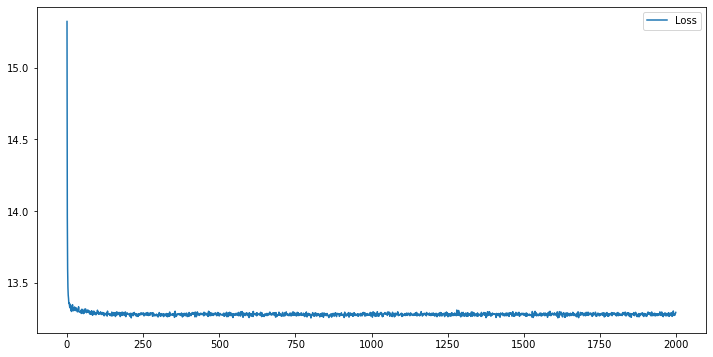

In [54]:
# and use them to train the model
loss_history = train(model, train_loader, criterion, optimizer, config)
loss_history_np = [loss.detach().cpu().numpy() for loss in loss_history]

plt.figure(figsize=(12, 6))
plt.plot(loss_history_np)
plt.legend(['Loss'])
plt.show()

In [55]:
def visualize_gam(x_values,input_dim, output_dim, vis_lat_features = False):
    # Plot learned functions
    fig, axes = plt.subplots(input_dim, output_dim, figsize=(15,30))

    feature_output_max = {} 
    feature_output_min = {}

    for j in range(output_dim):
        feature_output_max[f'output_{j}'] = []
        feature_output_min[f'output_{j}'] = []

    for i in range(input_dim):
        with torch.no_grad():
            feature_input = x_values
            for j in range(output_dim):
                if vis_lat_features:
                    feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                else:          
                    feature_output = model.NAM_output.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()  

                feature_output_max[f'output_{j}'].append(max(feature_output)) 
                feature_output_min[f'output_{j}'].append(min(feature_output))

    for i in range(input_dim):
        with torch.no_grad(): 
            for j in range(output_dim):
                ax1 = axes[i, j]
                if vis_lat_features:
                    feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                else:          
                    feature_output = model.NAM_output.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    
                ax1.scatter(x_values.cpu().numpy(), feature_output, label=f'Feature {i+1}')
                ax1.set_title(f'Feature {i+1} to output {j}')
                ax1.set_xlabel('Input')
                ax1.set_ylabel('Output')
                ax1.set_ylim([min(feature_output_min[f'output_{j}'])*1.3, max(feature_output_max[f'output_{j}'])*1.3])

    plt.tight_layout()
    plt.show()
    return

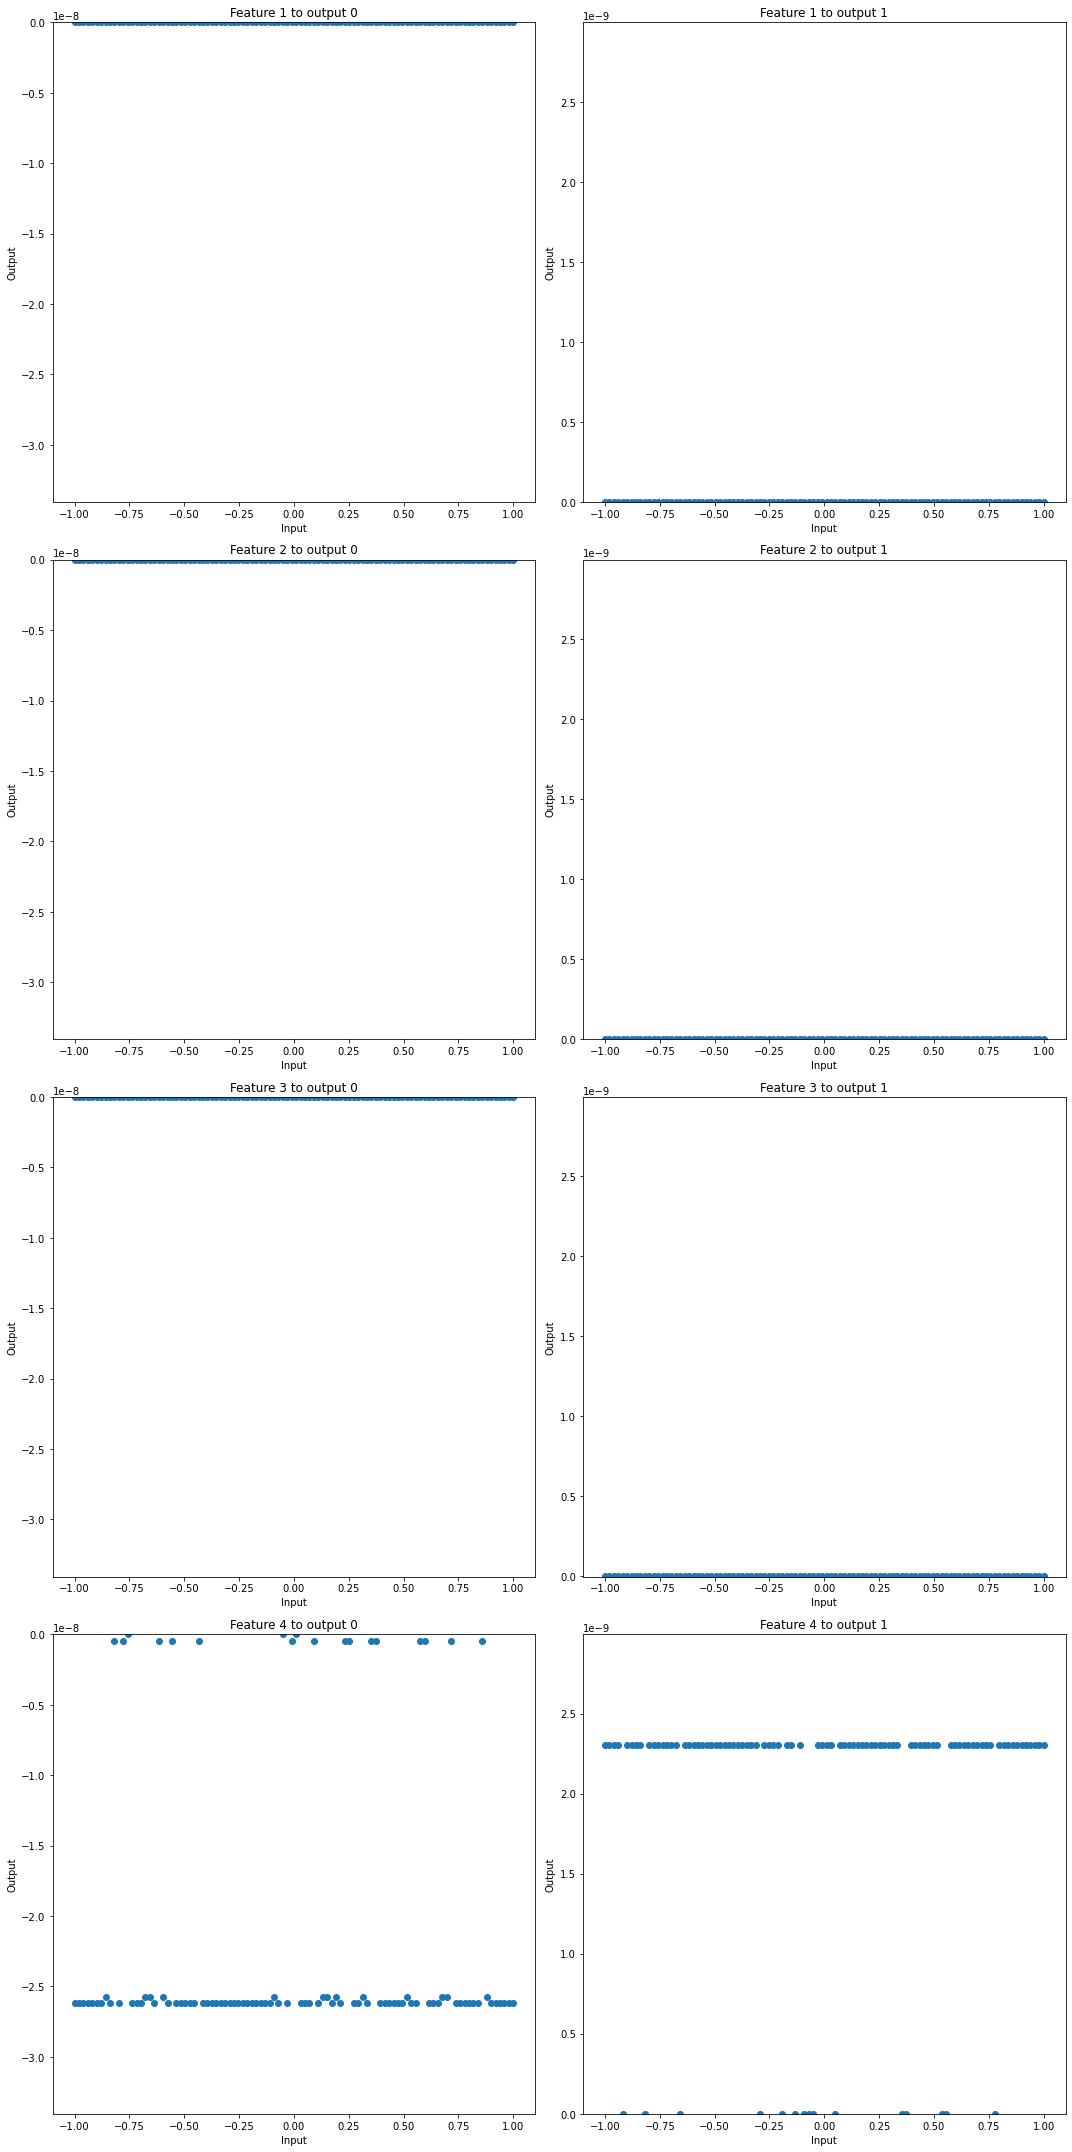

In [56]:
# Generate input values for plotting
x_values = torch.linspace(-1, 1, 100).reshape(-1, 1)  # 100 points between -1 and 1

vis_lat_features = False
input_dim = config['latent_dim']
output_dim = config['output_dim']
visualize_gam(x_values, input_dim, output_dim, vis_lat_features)

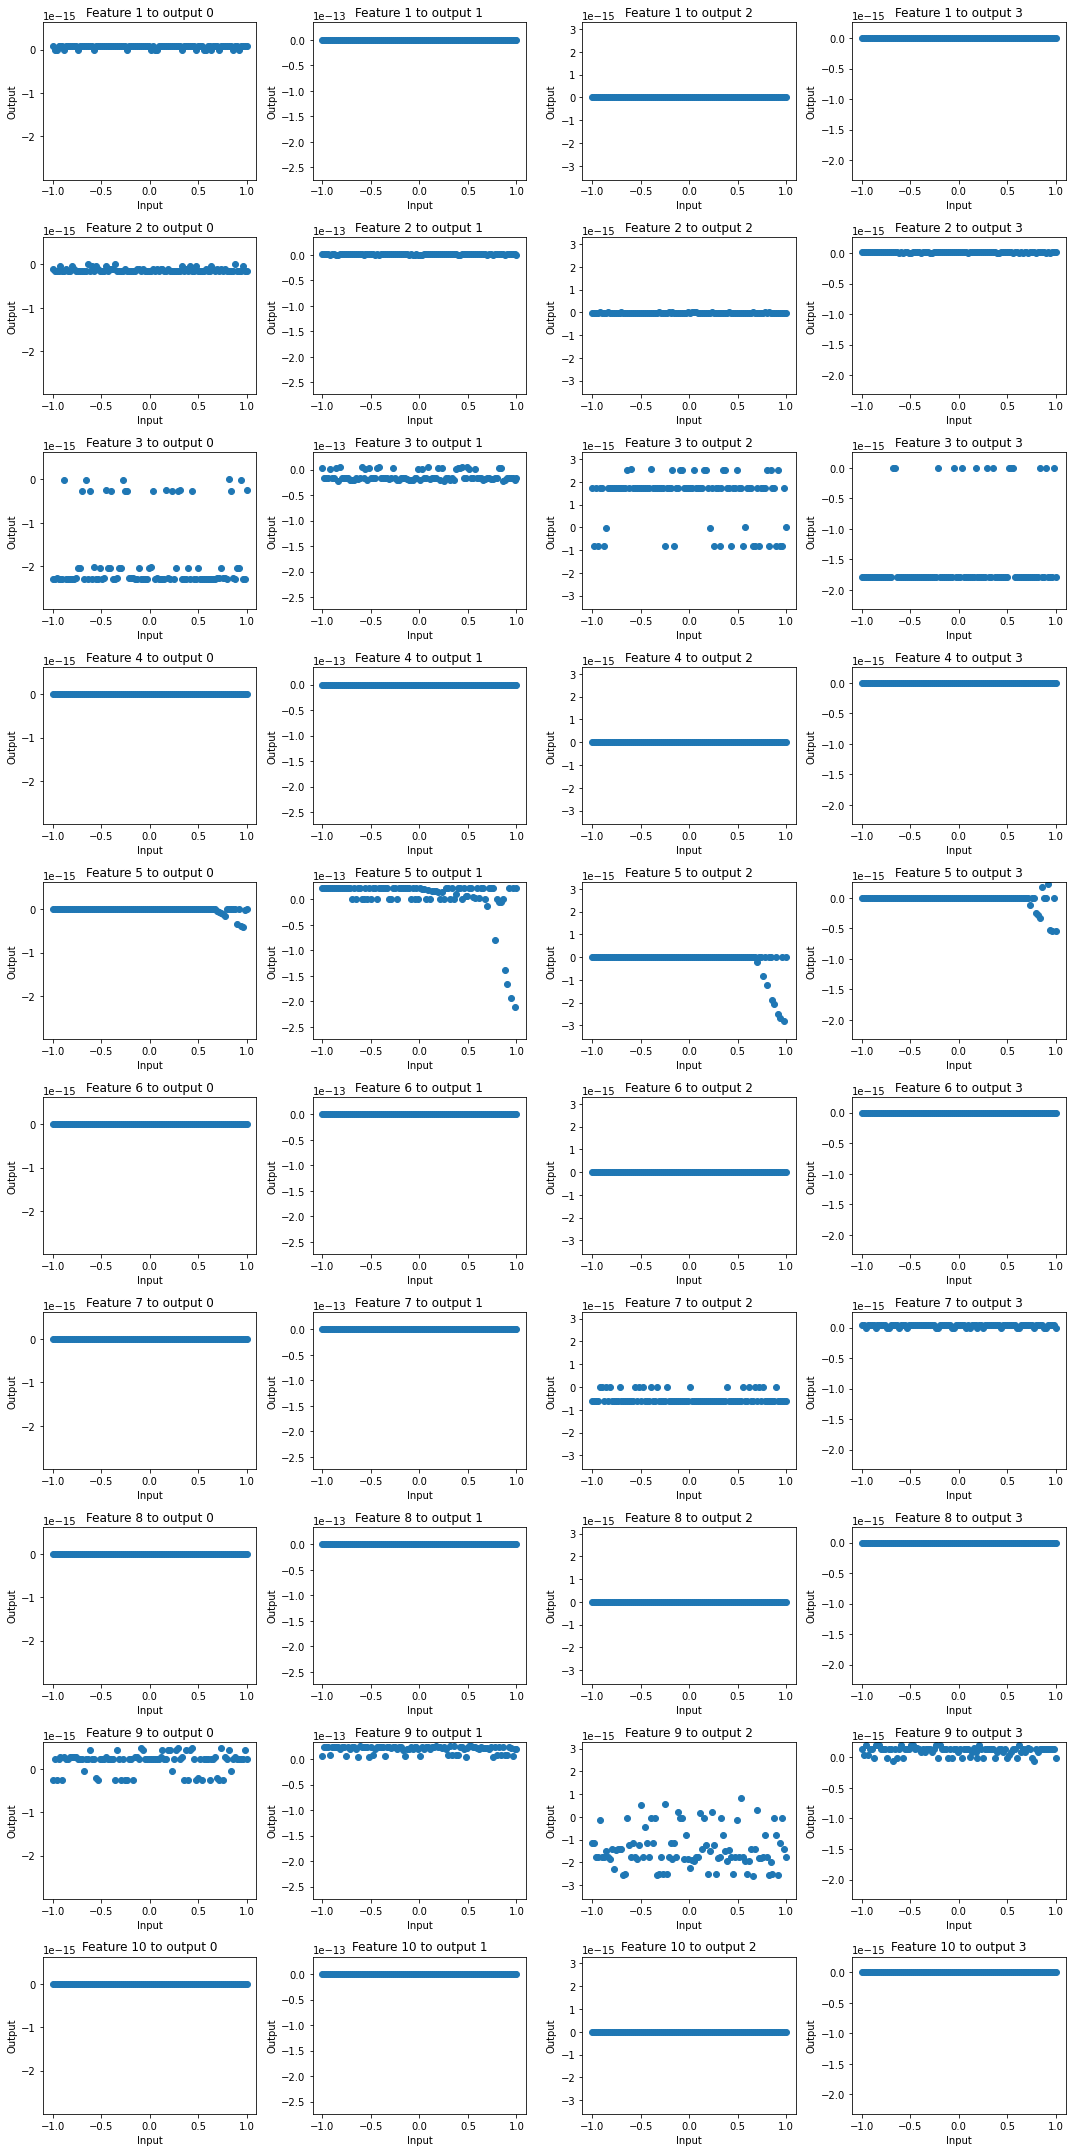

In [57]:
# Generate input values for plotting
x_values = torch.linspace(-1, 1, 100).reshape(-1, 1)  # 100 points between -1 and 1

vis_lat_features = True
input_dim = config['in_features']
output_dim = config['latent_dim']
visualize_gam(x_values, input_dim, output_dim, vis_lat_features)


# Old

In [10]:
# a basic numerical example that demonstrates the functionality of the key parts of the NeuralAdditiveModel class

if 0:
    import torch
    import torch.nn as nn

    # Simplified FeatureNN that outputs 3 values per feature (for 3 classes)
    class SimpleFeatureNN(nn.Module):
        def __init__(self, num_features, num_classes):
            super().__init__()
            self.input_layer = torch.nn.Linear(1, num_features)
            self.output_layer = torch.nn.Linear(num_features, num_classes)

        def forward(self, x):
            # Linear transformation: output = weight * x + bias
            x = self.input_layer(x)
            x = self.output_layer(x)
            return x

    # Simplified NeuralAdditiveModel
    class SimpleNeuralAdditiveModel(nn.Module):
        def __init__(self, num_features=5, num_classes=3):
            super().__init__()
            self.input_size = num_features
            self.feature_nns = nn.ModuleList([SimpleFeatureNN(num_features, num_classes) for _ in range(num_features)])
            self.bias = nn.Parameter(torch.tensor([0.5, 0.6, 0.7]))  # Bias for each class

        def forward(self, x):
            input_fe = self._feature_nns(x)
            print('-----------------')
            print(input_fe)
            # Collect outputs from each feature network
            f_out = torch.stack(input_fe, dim=-1)  # Shape: [batch_size, num_classes, num_features]
            print('-----------------')
            print(f_out)
            # Sum across features
            f_out_sum = f_out.sum(dim=-1)  # Shape: [batch_size, num_classes]
            print('-----------------')
            print(f_out_sum)
            # Add bias
            output = f_out_sum + self.bias
            print('-----------------')
            print(output)
            # Apply softmax to get class probabilities
            output = torch.softmax(output, dim=-1)
            print('-----------------')
            print(output)

            return output, f_out

        def _feature_nns(self, x):
            return [self.feature_nns[i](x[:, i].unsqueeze(-1)) for i in range(self.input_size)]

    # Step 3: Test the Model with a Simple Input

    # Define a simple input tensor with 2 features for 1 sample (batch_size = 1)
    x_input = torch.tensor([[1.0, 2.0, 1.5, 2.5, 3.0]])  # Shape: [1, 2] (1 sample, 2 features)
    print(x_input)
    # Initialize the simple model
    model = SimpleNeuralAdditiveModel(num_features=5, num_classes=3)

    # Perform a forward pass
    output, f_out = model(x_input)

In [80]:
input_size = x_data.shape[-1]
shallow_units = 500
hidden_units = (300, 100)

model = NeuralAdditiveModel(input_size=input_size,
                 shallow_units=shallow_units,
                 hidden_units=hidden_units,
                 shallow_layer = ExULayer,
                 hidden_layer = ReLULayer,
                 feature_dropout = 0.0,
                 hidden_dropout = 0.0,
                 )

lr=0.4
optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=lr,
                                  weight_decay=0.0
                             )
#criterion = torch.nn.MSELoss()
criterion = penalized_mse
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=100, epochs=1000)
#StepLR(optimizer, gamma=1, step_size=1)

train_dataset = TensorDataset(torch.tensor(x_data), torch.tensor(y_data))
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

<ipython-input-80-fcd7a1a4c170>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(x_data), torch.tensor(y_data))


train (100/5000) | loss = 31.83157: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.87it/s]
train (200/5000) | loss = 31.80177: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.38it/s]
train (300/5000) | loss = 31.78449: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.74it/s]
train (400/5000) | loss = 31.77496: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.61it/s]
train (500/5000) | loss = 31.76996: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.42it/s]
train (600/5000) | loss = 31.76748: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.91it/s]
train (700/5000) | loss = 31.76634: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.87it/s]
train (800/5000) | loss = 31.76584: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.98it/s]
train (900/5000) | loss = 31.76563: 100%

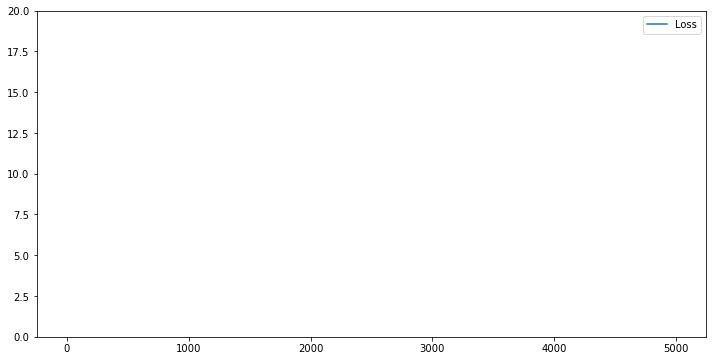

In [89]:
def train_one_epoch(model, criterion, optimizer, data_loader, device, epoch, n_epochs, verbose=False):
    pbar = tqdm.tqdm(enumerate(data_loader, start=1), total=len(data_loader), disable=not verbose)
    total_loss = 0
    for i, (x, y) in pbar:
        x, y = x.to(device), y.to(device)
        logits, fnns_out = model.forward(x)
        loss = criterion(logits, y, fnns_out, feature_penalty=0.0)
        #print(loss.item)
        total_loss += loss.item()
        #print(total_loss)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        pbar.set_description(f"train ({epoch+1}/{n_epochs}) | loss = {total_loss:.5f}")
        
    avg_loss = total_loss / len(data_loader)
    wandb.log({"loss": avg_loss})
    return avg_loss

history = []
n_epochs = 5000 #2000 #1000

for epoch in range(n_epochs):
    model = model.train()
    verbose = (epoch + 1) % 100 == 0
    total_loss = train_one_epoch(model, criterion, optimizer, train_loader, device, epoch, n_epochs, verbose=verbose)
    
    history.append(total_loss)
#     if verbose:
#         print(f"Epoch {epoch + 1} | Total Loss: {total_loss:.5f}")  
        
    scheduler.step()

plt.figure(figsize=(12, 6))
plt.plot(np.array(history))
plt.legend(['Loss'])
plt.ylim([0,20])
plt.show()

In [ ]:
def train_model(x_train, y_train, x_validate, y_validate, device):
    model = NeuralAdditiveModel(
        input_size=x_train.shape[-1],
        shallow_units=nam.data_utils.calculate_n_units(x_train, FLAGS.n_basis_functions, FLAGS.units_multiplier),
        hidden_units=list(map(int, FLAGS.hidden_units)),
        shallow_layer=ExULayer if FLAGS.shallow_layer == "exu" else ReLULayer,
        hidden_layer=ExULayer if FLAGS.hidden_layer == "exu" else ReLULayer,
        hidden_dropout=FLAGS.dropout,
        feature_dropout=FLAGS.feature_dropout).to(device)

    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=0.01,
                                  weight_decay=0.01)
    criterion = nam.metrics.penalized_mse if FLAGS.regression else nam.metrics.penalized_cross_entropy
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.995, step_size=1)

#     train_dataset = TensorDataset(torch.tensor(x_train), torch.tensor(y_train))
#     train_loader = DataLoader(train_dataset, batch_size=FLAGS.batch_size, shuffle=True)
#     validate_dataset = TensorDataset(torch.tensor(x_validate), torch.tensor(y_validate))
#     validate_loader = DataLoader(validate_dataset, batch_size=FLAGS.batch_size, shuffle=True)

#    n_tries = FLAGS.early_stopping_epochs
#    best_validation_score, best_weights = 0, None

    for epoch in range(5000):
        model = model.train()
        total_loss = train_one_epoch(model, criterion, optimizer, train_loader, device)
        logging.info(f"epoch {epoch} | train | {total_loss=}")

        scheduler.step()

#         model = model.eval()
#         metric, val_score = evaluate(model, validate_loader, device)
#         logging.info(f"epoch {epoch} | validate | {metric}={val_score}")

#         # early stopping
#         if val_score <= best_validation_score and n_tries > 0:
#             n_tries -= 1
#             continue
#         elif val_score <= best_validation_score:
#             logging.info(f"early stopping at epoch {epoch}")
#             break
#         best_validation_score = val_score
#         best_weights = copy.deepcopy(model.state_dict())

#     model.load_state_dict(best_weights)

    return model


def train_one_epoch(model, criterion, optimizer, data_loader, device):
    pbar = tqdm.tqdm(enumerate(data_loader, start=1), total=len(data_loader))
    total_loss = 0
    for i, (x, y) in pbar:
        x, y = x.to(device), y.to(device)
        logits, fnns_out = model.forward(x)
        loss = criterion(logits, y, fnns_out, feature_penalty=FLAGS.output_regularization)
        total_loss -= (total_loss / i) - (loss.item() / i)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"train | loss = {total_loss:.5f}")
    return total_loss